In [3]:
import os
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#paths
data_path = './data/behavioural_data'
figures_path = './figures'

In [5]:
files = np.sort(np.array(os.listdir(data_path)))
files = [file for file in files if 'order' not in file]
paired_files = [(files[i], files[i+1]) for i in range(0, len(files)-1, 2)]

data_df = pandas.DataFrame({})

for imagery_score, playlist_timestamps in paired_files:
    #supplemental run data 
    subject = imagery_score[:6]
    run_i = imagery_score.find('run-')+len('run-')
    run = imagery_score[run_i:run_i+2]
    run = int(run[0]) if run[-1] == '_' else int(run)
    session = int(imagery_score[imagery_score.find('ses-00')+len('ses-00')])
    
    subject_runs_order = 'S{}_Playlist_order.tsv'.format(subject[1:])
    order = pandas.read_csv(os.path.join(data_path, subject_runs_order), sep=' ')

        
    i = order.loc[(order['run']==run) & (order['session']==session)].index
    playlist = int(order.playlist.iloc[i].values[0])
    repetition = int(order.repetition.iloc[i].values[0])
    
    #extract data from tsv
    score_path = os.path.join(data_path, imagery_score)
    score_df = pandas.read_csv(score_path, sep='\t')
    timestamps_path = os.path.join(data_path, playlist_timestamps)
    timestamps_df = pandas.read_csv(timestamps_path, sep='\t')
    
    #manage df
    score_df.drop('question', axis='columns', inplace=True)
    timestamps_df.drop('path', axis='columns', inplace=True)
    run_df = pandas.concat([timestamps_df, score_df], axis='columns', join='outer')
    run_df.drop('track', axis='columns', inplace=True) 
    run_df['sub'] = subject
    run_df['session'] = session
    run_df['run'] = run
    run_df['playlist'] = playlist
    run_df['repetition'] = repetition

    data_df = pandas.concat([data_df, run_df], axis='rows', join='outer', ignore_index=True)
#data_df.to_csv('sub_session_data.tsv', sep="\t")

In [6]:
#sub-06 had a familiar track repeated 2 times in the first playlist (11 tracks instead of 10)
print(data_df.loc[(data_df['sub']=='sub-06')&
                  (data_df['session']==1)&
                  (data_df['title']=='The_Office_(Main_Theme)_silenced.wav')])
data_df.drop(545, inplace=True)

    Groupe    category                                 title  \
541      F  Orchestral  The_Office_(Main_Theme)_silenced.wav   
545      F  Orchestral  The_Office_(Main_Theme)_silenced.wav   

     silence_duration  total_duration       onset  value confirmation     sub  \
541                16            62.0   76.082241      4          yes  sub-06   
545                16            62.0  331.742244      4          yes  sub-06   

     session  run  playlist  repetition  
541        1    1         1           1  
545        1    1         1           1  


In [7]:
from scipy.stats import wilcoxon, ttest_ind

for sub in ['sub-01', 'sub-02', 'sub-03', 'sub-06']:
    unfamiliar = data_df['value'].loc[(data_df['Groupe']=='U')&
                        (data_df['sub']==sub)].values
    familiar = data_df['value'].loc[(data_df['Groupe']=='F')&
                        (data_df['sub']==sub)].values
    stat = ttest_ind(unfamiliar, familiar)
    print(sub, stat)
    print('familiar', np.median(familiar), np.mean(familiar))
    print('unfamiliar', np.median(unfamiliar), np.mean(unfamiliar))
            

sub-01 TtestResult(statistic=-16.686860025950022, pvalue=3.0422027427158697e-38, df=178.0)
familiar 3.0 3.2666666666666666
unfamiliar 1.0 1.4777777777777779
sub-02 TtestResult(statistic=-12.567583916373076, pvalue=2.4374267437296138e-26, df=178.0)
familiar 3.0 2.888888888888889
unfamiliar 1.0 0.8
sub-03 TtestResult(statistic=-15.605818551512812, pvalue=3.71613289478647e-35, df=178.0)
familiar 3.0 3.0444444444444443
unfamiliar 0.0 0.5666666666666667
sub-06 TtestResult(statistic=-25.516052876185586, pvalue=2.2948635324083088e-61, df=178.0)
familiar 4.0 3.688888888888889
unfamiliar 0.0 0.34444444444444444


In [39]:
for sub in ['sub-01', 'sub-02', 'sub-03', 'sub-06']:
    for Groupe in ['U', 'F']:
        for paired_rep in [(1,2), (2,3), (1,3)]:
    
            rep1 = data_df.loc[(data_df['Groupe']==Groupe)&
                                    (data_df['sub']==sub)&
                                    (data_df['repetition']==paired_rep[0])]
            sorted_rep1 = rep1.sort_values(by='title')
            val1 = sorted_rep1['value'].values
            
            rep2 = data_df.loc[(data_df['Groupe']==Groupe)&
                                    (data_df['sub']==sub)&
                                    (data_df['repetition']==paired_rep[1])]
            sorted_rep2 = rep2.sort_values(by='title')
            val2 = sorted_rep2['value'].values

            stat, p_value = wilcoxon(val1, val2)
            print(sub, Groupe, paired_rep, p_value, p_value<0.05)

sub-01 U (1, 2) 0.0003114909767673833 True
sub-01 U (2, 3) 0.6373518882339371 False
sub-01 U (1, 3) 0.004660881188373498 True
sub-01 F (1, 2) 0.012419330651552265 True
sub-01 F (2, 3) 0.8083651559145103 False
sub-01 F (1, 3) 0.043266287956991244 True
sub-02 U (1, 2) 0.08808151166219029 False
sub-02 U (2, 3) 0.3457785861511603 False
sub-02 U (1, 3) 0.007632881787792299 True
sub-02 F (1, 2) 0.25683925795785656 False
sub-02 F (2, 3) 0.28504940740261275 False
sub-02 F (1, 3) 0.034808478811867126 True
sub-03 U (1, 2) 0.021920290335159895 True
sub-03 U (2, 3) 0.1175598011456681 False
sub-03 U (1, 3) 0.30493703992157595 False
sub-03 F (1, 2) 0.02217863907691186 True
sub-03 F (2, 3) 0.02577762176130498 True
sub-03 F (1, 3) 0.5184271239077466 False
sub-06 U (1, 2) 0.7054569861112734 False
sub-06 U (2, 3) 0.4496917979688909 False
sub-06 U (1, 3) 0.27948536825112646 False
sub-06 F (1, 2) 0.33399825582199794 False
sub-06 F (2, 3) 0.8539232992870668 False
sub-06 F (1, 3) 0.3303900488487942 False


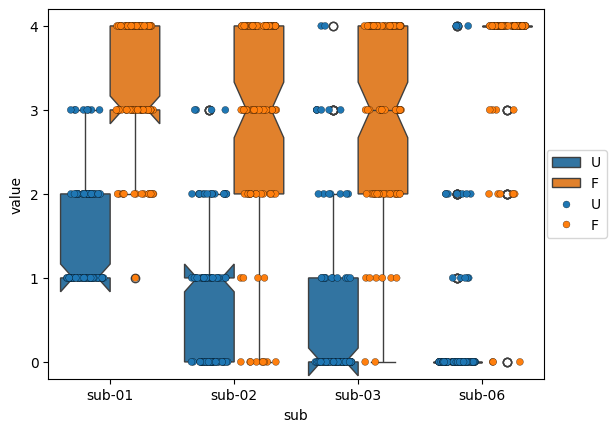

In [44]:
sns.boxplot(data=data_df, x="sub", y="value", hue="Groupe", notch=True)
sns.stripplot(data=data_df, x="sub", y="value", hue="Groupe", dodge=True, jitter=0.3, edgecolor='k', linewidth=0.2)
plt.legend(loc='center right', bbox_to_anchor=(1.14, 0.5))
plt.yticks(range(5))

plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe'))

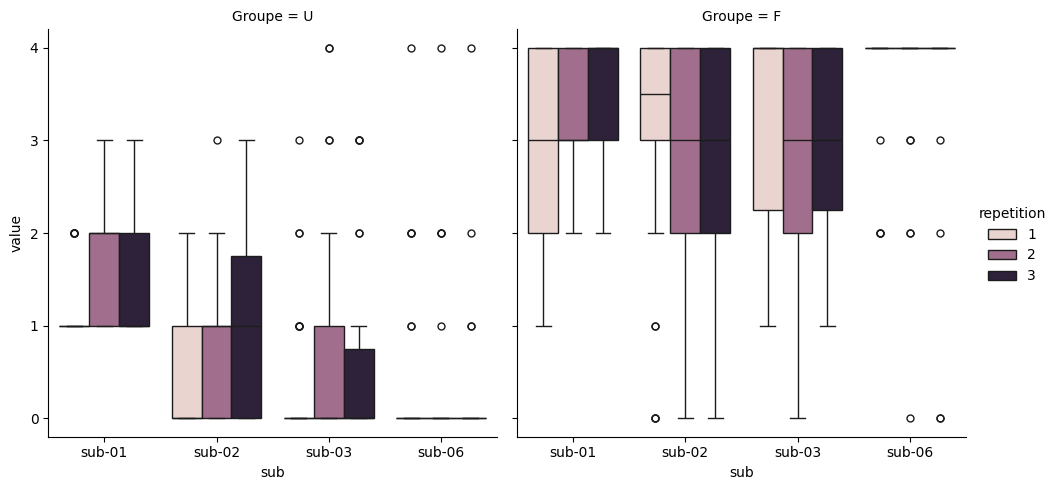

In [29]:
sns.catplot(data=data_df, x="sub", y="value", hue="repetition", col="Groupe", kind='box')
plt.yticks(range(5))
plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe_Repetition'))

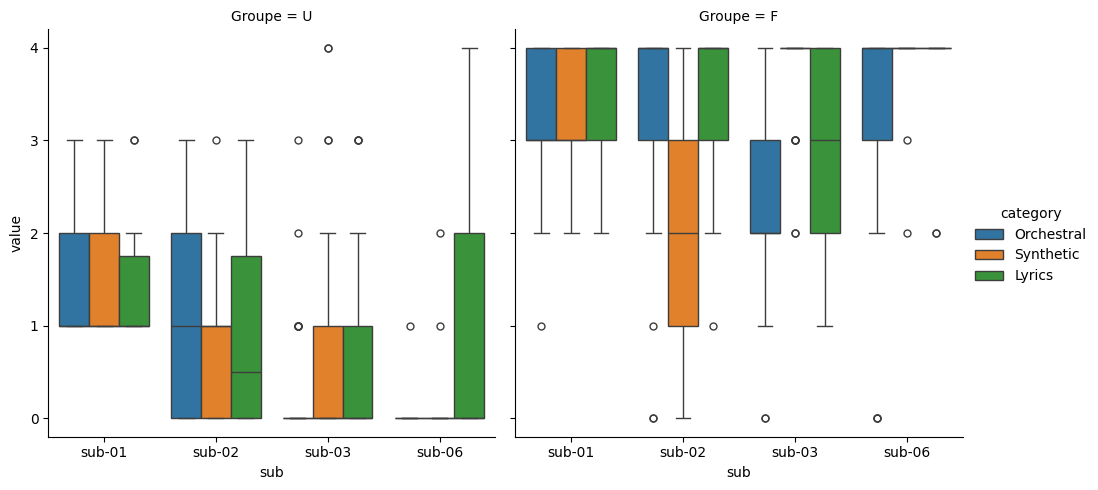

In [30]:
sns.catplot(data=data_df, x="sub", y="value", hue="category", col="Groupe", kind='box')
plt.yticks(range(5))
plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe_Category'))

In [4]:
print(data_df.loc[data_df['sub']=='sub-01'])

    Groupe    category                                              title  \
0        U  Orchestral  Star_Trek_the_Next_Generation_(Main_Title)_sil...   
1        F   Synthetic  Super_Mario_Bros_(NES)_Music_Overworld_Theme_s...   
2        F      Lyrics     Everybody_Wants_To_Rule_The_World_silenced.wav   
3        U  Orchestral  Main_Title_Terminator_2_Theme_(Remastered_2017...   
4        U      Lyrics                         Synchronicity_silenced.wav   
..     ...         ...                                                ...   
175      U  Orchestral                            The_Moldau_silenced.wav   
176      F  Orchestral                        Gnossienne_No1_silenced.wav   
177      F   Synthetic  Celeste_Original_Soundtrack_03_Resurrections_s...   
178      U      Lyrics                         Make_Em_Laugh_silenced.wav   
179      F   Synthetic            Super_Mario_Bros_3_Airship_silenced.wav   

     silence_duration  total_duration       onset  value confirmation     s